## Assignment 1 - Natural Language Processing
### Problem Statement: Implement Word2vec from scratch.
1.  Train a neural network to generate word embeddings in the form of
a weight matrix.
2.   Embedding layers can be trained to generate custom embeddings
in popular neural network libraries like TensorFlow or PyTorch.  
3.  You are free to train on large datasets such as Wikipedia.
4.  Test the semantics, embedding vectors to see relationships such as
“king - man + woman = queen.”

#### Bhuvana Kanakam - SE21UCSE035  - March 3, 2024

## What is Word Embedding ?
computer can understand numbers rather than words, so a way to represent words as a dense set of numbers called vectors is called word embeddings. They are mapped in a higher dimensional vector where semnatically (meaninful) similar words are placed next to each other in the vector space.

## Word2Vec
**transferring words into vectors**
##### A technique of word embedding in natural language processing is Word2Vec. This is better than the TF-IDF technique, which looks at the most relevant words in the documents but fails to look at the context of the word. But, Word2Vec looks at the context, based on the probability. It is a machine learning algorithm. Looks at the possibility of a word occuring given another word existing.


### Import The Libraries

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Text - Data
inorder to do word embedding, I need data. I am taking some text from wikipedia on *Medical Images*. [link text](https://en.wikipedia.org/wiki/Medical_imaging)



#### Raw Text
```
Medical imaging is the technique and process of imaging the interior of a body for clinical analysis and medical intervention,
as well as visual representation of the function of some organs or tissues (physiology). Medical imaging seeks to reveal internal
structures hidden by the skin and bones, as well as to diagnose and treat disease. Medical imaging also establishes a database
of normal anatomy and physiology to make it possible to identify abnormalities. Although imaging of removed organs and tissues
can be performed for medical reasons, such procedures are usually considered part of pathology instead of medical imaging.
```

In [ ]:
text = ''' Medical imaging is the technique and process of imaging the interior
of a body for clinical analysis and medical intervention, as well as visual
representation of the function of some organs or tissues (physiology).
Medical imaging seeks to reveal internal structures hidden by the skin and bones,
as well as to diagnose and treat disease. Medical imaging also establishes a
database of normal anatomy and physiology to make it possible to identify abnormalities.
Although imaging of removed organs and tissues can be performed for medical reasons,
such procedures are usually considered part of pathology instead of medical imaging.'''

### PreProcessing of the Data
In normalisation of the text, we basically mean to get it in a standard format for our an easier processing. And usually there are few steps.
1. Tokenise the tokens to smaller words
2. Format the words : remove stop words, lower case
3. Segment the sentances
4. Lemmatization and stemming are part of the normalisation process

#### Tokenisation of the text
`tokens = word_tokenize(text)`

#### Remove Punctuation : Normalization
`tokens = [word.lower() for word in tokens if word.isalnum()]`

#### Remove Stop Words


```
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if not word in stop_words]
```



#### Lemmatize the tokens


```
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(word) for word in tokens]
```



#### Pre Processing Function


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

### Training Data
The data are goind to be in the form of matrices, and here. the tokens are strings. which would be one-hot vectors. to train word2vec, we need input and target values. and we know that, we look at center - context words.

#### Build Vocabulary


In [ ]:
word_sequence = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

In [ ]:
word_list = list(set(word_sequence))
word_dict = {w: i for i, w in enumerate(word_list)}
voc_size = len(word_list)

#### One Hot Encoding and Example Training Data

In [ ]:
print("Example Training Data:")
for target_word, context_words in training_data[:5]:
    print(f"Target Word: {target_word} | Context Words: {context_words}")

print("\nExample One-Hot Encoding:")
target_word = training_data[0][0]
one_hot_target = np.zeros(len(word_to_index))
one_hot_target[word_to_index[target_word]] = 1
print(f"One-Hot Encoding for '{target_word}':\n{one_hot_target}")

Example Training Data:
Target Word: medical | Context Words: ['imaging', 'technique']
Target Word: imaging | Context Words: ['medical', 'technique', 'process']
Target Word: technique | Context Words: ['medical', 'imaging', 'process', 'imaging']
Target Word: process | Context Words: ['imaging', 'technique', 'imaging', 'interior']
Target Word: imaging | Context Words: ['technique', 'process', 'interior', 'body']

Example One-Hot Encoding:
One-Hot Encoding for 'medical':
[0. 0. 0. ... 0. 0. 0.]


The one-hot encoding is a numpy array where the index corresponding to the target word's index in the vocabulary is set to 1, and all other indices are 0.

### Model Implementation

#### Hyper Parameters

In [ ]:
embedding_size = 100
batch_size = 20
num_negative_samples = 5
window_size = 5

In [ ]:
embeddings, word_to_index, index_to_word = train_word2vec(text)

<ipython-input-244-2114e21e6af0>:17: RuntimeWarning: overflow encountered in exp
  error = np.dot(embeddings[target_index], context_vector) - np.log(np.sum(np.exp(embeddings @ context_vector)))
<ipython-input-244-2114e21e6af0>:17: RuntimeWarning: invalid value encountered in matmul
  error = np.dot(embeddings[target_index], context_vector) - np.log(np.sum(np.exp(embeddings @ context_vector)))


#### Skip Gram Model

In [ ]:
skip_grams = [(word_dict[word_sequence[i]], word_dict[word_sequence[i + j]])
              for i in range(window_size, len(word_sequence) - window_size)
              for j in range(-window_size, window_size + 1) if j != 0]

#### Training

In [ ]:
class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(Word2Vec, self).__init__()
        self.embedding = nn.Embedding(voc_size, embedding_size)
        self.output = nn.Linear(embedding_size, voc_size)

    def forward(self, x):
        embed = self.embedding(x)
        out = self.output(embed)
        return out

#### Negative Sampling

In [ ]:
def negative_sampling(batch, model, optimizer, criterion, num_negative_samples):
    targets, contexts = zip(*batch)
    target_inputs = torch.LongTensor(targets)
    context_inputs = torch.LongTensor(contexts)

    optimizer.zero_grad()
    output_pos = model(target_inputs)
    loss_pos = criterion(output_pos, context_inputs)

    batch_size = len(batch)
    negative_samples = torch.randint(0, voc_size, (batch_size, num_negative_samples))
    output_neg = model(negative_samples.view(-1))
    output_neg = output_neg.view(batch_size, num_negative_samples, -1)

    target_neg = torch.zeros(batch_size, num_negative_samples, voc_size)
    for i in range(batch_size):
        for j in range(num_negative_samples):
            target_neg[i, j, negative_samples[i, j]] = 1

    loss_neg = criterion(output_neg, target_neg)
    loss = loss_pos + loss_neg.mean()

    loss.backward()
    optimizer.step()

    return loss.item()

#### Model Initalization

In [ ]:
model = Word2Vec(voc_size, embedding_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#### Training Loop

In [ ]:
losses = []
for epoch in range(5):
    total_loss = 0
    for i in range(0, len(skip_grams), batch_size):
        batch = skip_grams[i:i+batch_size]
        total_loss += negative_sampling(batch, model, optimizer, criterion, num_negative_samples)
    losses.append(total_loss)

#### Embeddings

In [ ]:
embeddings = model.embedding.weight.detach().numpy()

### Plotting

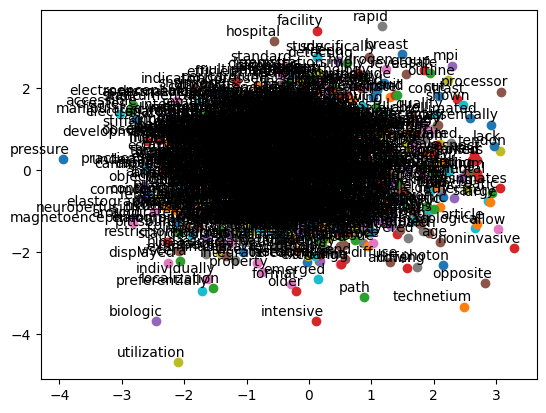

In [ ]:
for i, word in enumerate(word_list):
    embedding = embeddings[i]
    x, y = embedding[0], embedding[1]  # Assuming 2-dimensional embeddings
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

#### Predicted Output

In [ ]:
def predict_context(model, word_dict, target_word, top_k=5):
    target_idx = word_dict[target_word]
    target_input = torch.LongTensor([target_idx])
    output = model(target_input)

    _, top_indices = torch.topk(output, k=top_k, dim=1)
    top_indices = top_indices.squeeze().tolist()

    context_words = [word_list[idx] for idx in top_indices]
    return context_words

target_word = "medical"  # Specify the target word
context_words = predict_context(model, word_dict, target_word)
print("Predicted context words for '{}':".format(target_word))
print(context_words)

Predicted context words for 'medical':
['imaging', 'medical', 'image', 'used', 'clinical']


### Conclusion

While I'm not implementing every detail of the neural network architecture and optimization algorithms from the most fundamental level, this code does involve defining the model, loss function, optimizer, and training loop, which are essential components of implementing a Word2Vec model. If you're looking for an even more basic implementation from scratch, it would involve writing the mathematical operations for the neural network layers (such as embedding lookup and linear transformation) and optimization algorithms (like stochastic gradient descent) without utilizing existing deep learning frameworks like PyTorch or TensorFlow. This level of implementation would be considerably more complex and time-consuming.